# Some attempt at Particle Tracking

In [168]:
# Importing things

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq

from lab_functions import *

In [169]:
# where is the data?
loc = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/2024-03-11/'
filename = 'Results.csv'

# read in as dataframe
df = pd.read_csv(loc + filename)

# select x and y positions of bead for all 83 frames
# get rid of anomalous last point
x = np.array(df['x'])[:-1]
y = np.array(df['y'])[:-1]

In [170]:
# Conversion Factor
pixels_microns = 15.36

x_mic = x*(1/pixels_microns)
y_mic = y*(1/pixels_microns)

Text(0, 0.5, 'y / Microns')

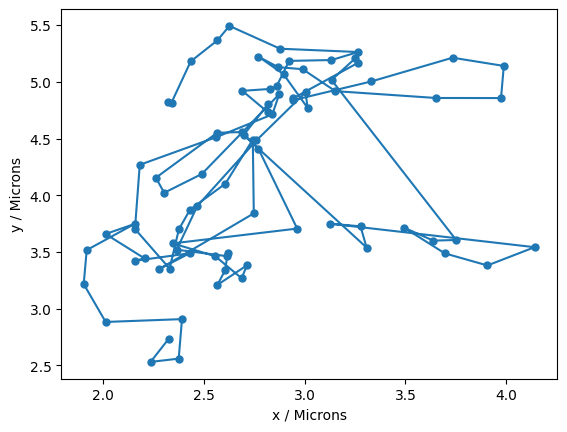

In [171]:
# Plot x and y trajectory

plt.errorbar(x_mic,y_mic, ms = 5, fmt = 'o', linestyle = '-')
plt.xlabel('x / Microns')
plt.ylabel('y / Microns')

Text(0, 0.5, 'Position / Microns')

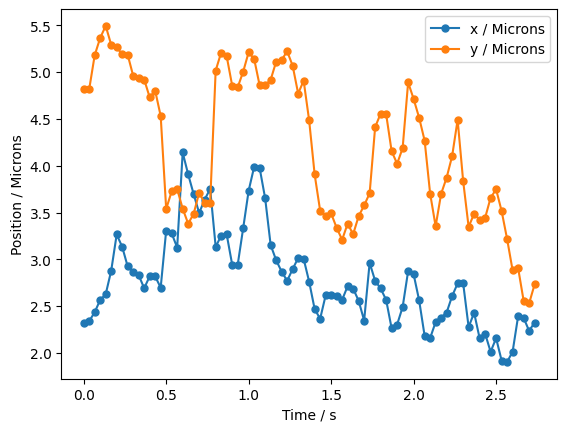

In [172]:
# Frames per second on camera
fps = 30
fps_err = 1

# Set time axis in seconds
time = np.arange(x.size) / 30

# plot x and y over time
plt.errorbar(time,x_mic, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position / Microns')

Text(0, 0.5, 'Position around zero / Microns')

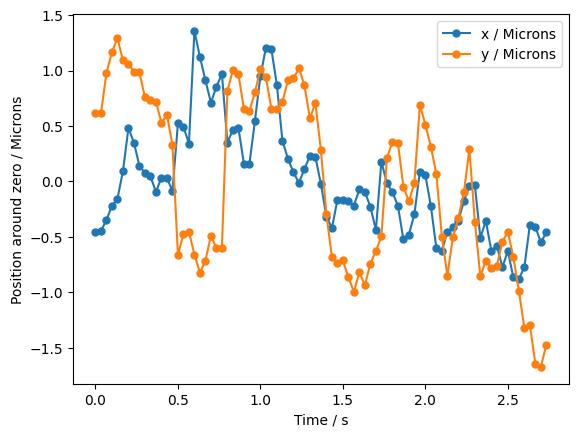

In [173]:
# Find mean of particle tracks to centre data on zero
x_mean = np.mean(x_mic)
y_mean = np.mean(y_mic)

# Subtract mean from data
x_mic0 = x_mic - x_mean
y_mic0 = y_mic - y_mean

# plot x and y over time
plt.errorbar(time,x_mic0, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic0, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position around zero / Microns')

Text(0, 0.5, 'Fourier Transform Squared / Arb Units')

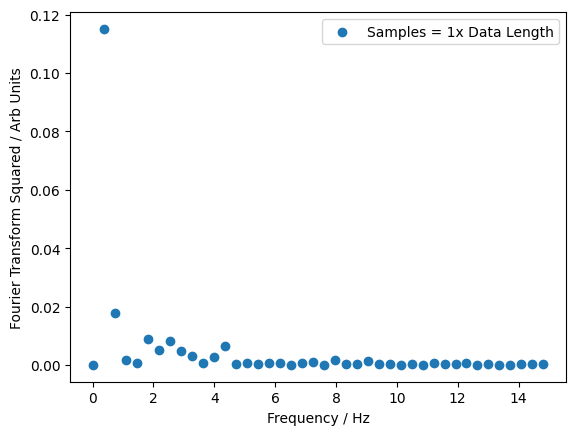

In [174]:
def fourier_calc(data, sample_number):

    # Compute transform and normalise by length / 2
    fast_four = rfft(data, n = sample_number) / (len(data) / 2)

    # Compute amplitude squared and divide by measurement time
    ps = np.abs(fast_four)**2 / time[-1]

    # Calculate frequency components (is the sample spacing right?)
    freq = rfftfreq(sample_number, d=1.0/fps)

    return ps, freq

ps, freq = fourier_calc(x_mic0, x_mic0.size)

# Plot using above function
plt.scatter(freq, ps, label = 'Samples = {}x Data Length'.format(1))
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Fourier Transform Squared / Arb Units')

C:\Users\abiga\AppData\Local\Temp\ipykernel_23796\1632605421.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8,0)


(1e-08, 3.9873373128072704)

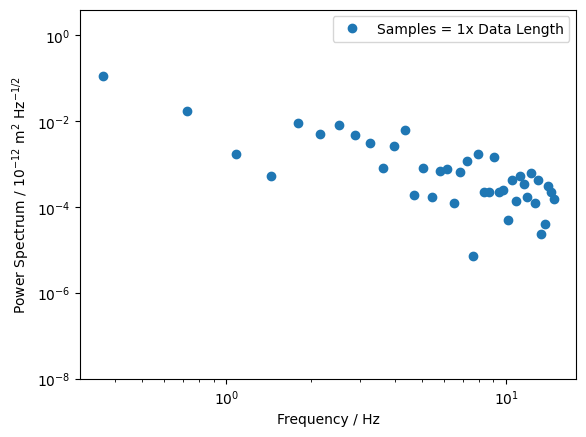

In [175]:
# Use a log scale
plt.loglog(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
plt.ylim(1e-8,0)

C:\Users\abiga\AppData\Local\Temp\ipykernel_23796\3497643497.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8,0)


(1e-08, 4.298904898134599)

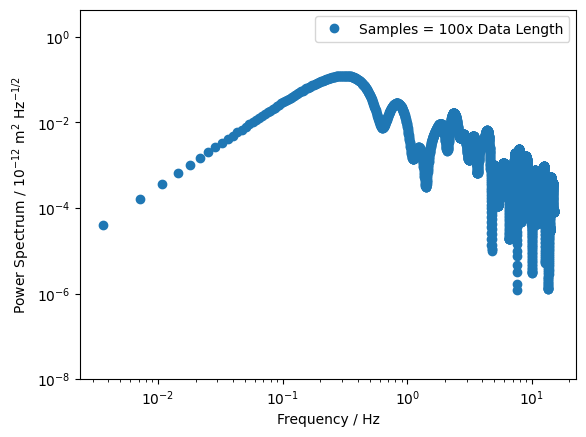

In [176]:
# Use a log scale

psh, freqh = fourier_calc(x_mic0,100*x_mic0.size)

plt.loglog(freqh, psh, label = 'Samples = {}x Data Length'.format(100), linestyle = '', marker = 'o')
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
plt.ylim(1e-8,0)

In [177]:
# Fit the above to Lorenzian Power Spectrum

def Lorentzian(x,A,f_0):
    return A / ((1 + x/f_0)**2)

ig = np.array([0.12,0.1])

# Fits to no padding and padding in fft
''' WARNING: Arb error here. Needs work '''
yfit, parameters, perrors, chisq_reduced, p_value, dof = fit_labs(freq,ps,0.1,Lorentzian,ig)
yfith, parametersh, perrorsh, chisq_reducedh, p_valueh, dofh = fit_labs(freqh,psh,0.1,Lorentzian,ig)

C:\Users\abiga\AppData\Local\Temp\ipykernel_23796\2190128095.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(1e-8,0)


The Amplitude of the Lorentzian is 0.040893691758267375 10^-12 m$^2$ Hz^-1/2$
The Cutoff Frequency is 2.160667252205341 Hz
The reduced chi squared value for the fit is 0.023912795596090088


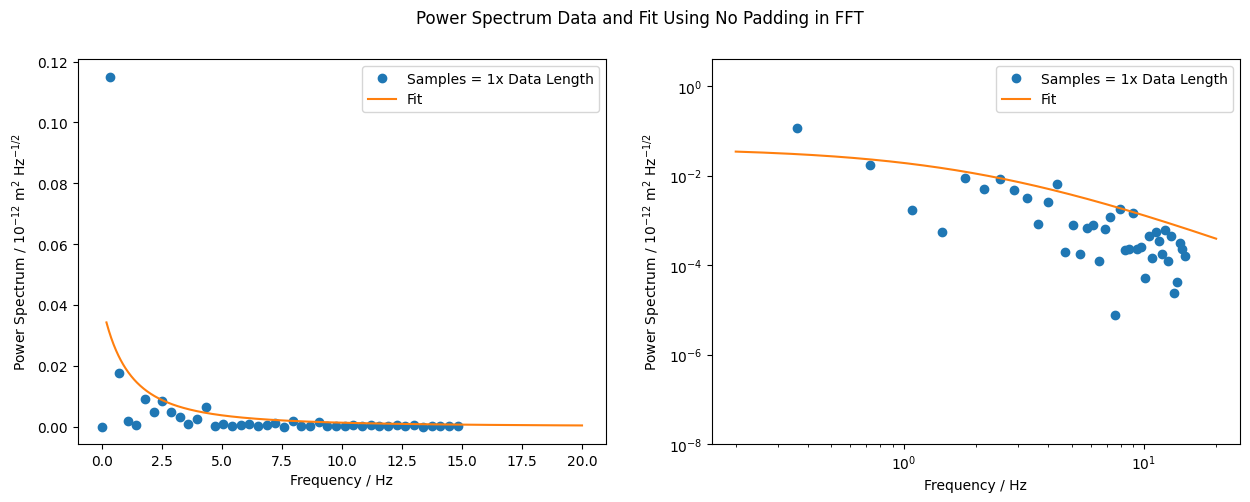

In [178]:
# Plot with Fit
# Use a log scale

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))

some_fs = np.linspace(0.2,20,1000)

fig.suptitle('Power Spectrum Data and Fit Using No Padding in FFT')

# Axis 1 - normal scale
ax1.plot(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax1.plot(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit', linestyle = '-')
ax1.legend()
ax1.set_xlabel('Frequency / Hz')
ax1.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')

# Axis 2 - log scale
ax2.loglog(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax2.loglog(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit', linestyle = '-')
ax2.legend()
ax2.set_xlabel('Frequency / Hz')
ax2.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax2.set_ylim(1e-8,0)

print('The Amplitude of the Lorentzian is {} 10^-12 m$^2$ Hz^-1/2$'.format(parameters[0]))
print('The Cutoff Frequency is {} Hz'.format(parameters[1]))
print('The reduced chi squared value for the fit is {}'.format(chisq_reduced))

C:\Users\abiga\AppData\Local\Temp\ipykernel_23796\765476583.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(1e-8,0)


The Amplitude of the Lorentzian is 0.0750773115872087 10^-12 m$^2$ Hz^-1/2$
The Cutoff Frequency is 1.1382755627864205 Hz
The reduced chi squared value for the fit is 0.011288432209760915


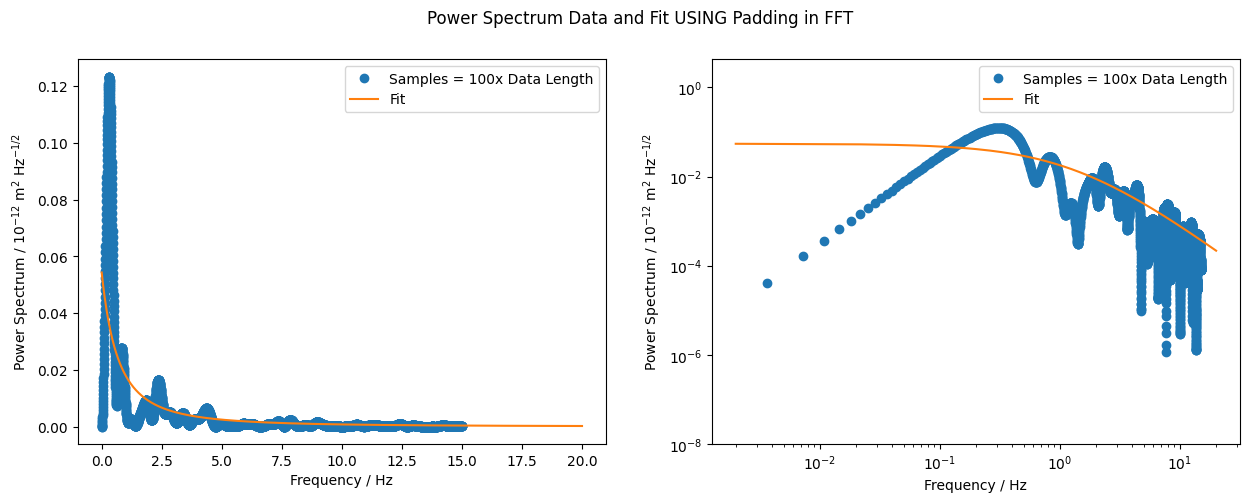

In [179]:
# Plot with Fit
# Use a log scale

fig2, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))

fig2.suptitle('Power Spectrum Data and Fit USING Padding in FFT')

some_fsh = np.linspace(0.002,20,1000)

# Axis 1 - normal scale
ax1.plot(freqh, psh, label = 'Samples = {}x Data Length'.format(100), linestyle = '', marker = 'o')
ax1.plot(some_fsh, Lorentzian(some_fs,parametersh[0],parametersh[1]), label = 'Fit', linestyle = '-')
ax1.legend()
ax1.set_xlabel('Frequency / Hz')
ax1.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')

# Axis 2 - log scale
ax2.loglog(freqh, psh, label = 'Samples = {}x Data Length'.format(100), linestyle = '', marker = 'o')
ax2.loglog(some_fsh, Lorentzian(some_fs,parametersh[0],parametersh[1]), label = 'Fit', linestyle = '-')
ax2.legend()
ax2.set_xlabel('Frequency / Hz')
ax2.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax2.set_ylim(1e-8,0)

print('The Amplitude of the Lorentzian is {} 10^-12 m$^2$ Hz^-1/2$'.format(parametersh[0]))
print('The Cutoff Frequency is {} Hz'.format(parametersh[1]))
print('The reduced chi squared value for the fit is {}'.format(chisq_reducedh))